# MCMC Polynomial Fitting
- Phase Variation = 1st or 2nd order sinusoid
- Polynomial = 2nd-5th order polynomial
- Can also do ellipsoidal varations

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [1]:
'''Import Package'''

import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

import numpy as np
import time as t
import os, sys

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import helpers
import astro_models
import make_plots

import inspect

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.time
from astropy.stats import sigma_clip
from astropy.table import Table, Column

%matplotlib inline

In [2]:
user = 'Taylor'

In [3]:
'''SETUP for Taylor'''
if user == 'Taylor':
    planet   = 'WASP-12b'            # Name of the planet

    channel  = 'ch1'                 # Spitzer channel
    mode     = 'Poly2_v1_ellipse'     # Detector model and Phase variation order
    phoption = '3umExactCircular4_6' # photometry option
    nFrames  = 64                    # number of frames per binned data point
    initializeWithOld = False        # initial with previous mcmc results
    nBurnInSteps = 3e5               # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e5           # number of steps to use with mcmc production run
    
    # Master path
    mainpath   = '/home/taylor/Documents/Research/spitzer/WASP-12b/analysis/'
    # path where outputs are saved
    foldername = mainpath + channel +'/' + phoption + '/'
    savepath   = foldername + mode + '/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs4801.dat'
    filenamef  = channel + '_datacube_full_AORs4801.dat'
    # Path to previous mcmc results (optional)
    oldFname   = savepath +'ResultMCMC_'+mode+'_Params.npy'
    
    if channel=='ch1':
        timeaor1 = 56638.7346502+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
        timeaor2 = 56639.234842+1/3600/24   #Taken from BMJD from 1st file of 3nd aor

        ignoreFrames = [0,1]

    else:
        timeaor1 = 56641.9990393+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
        timeaor2 = 56642.4991651+1/3600/24  #Taken from BMJD from 1st file of 3nd aor

        ignoreFrames = [0,1]

    breaks = np.array([timeaor1, timeaor2])

    # non-zero if you cut initial data set (DANGER)
    cut = 0

In [4]:
if user=='Taylor':
    
    # parameter you do not wish to fit
    dparams = ['per','ecosw','esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.t0    = 56176.168258                    # BMJD time
    p0_obj.per   = 1.0914203                       # in days
    p0_obj.rp    = 0.11785                         # radius (in stellar radii) 
    p0_obj.a     = 3.039                           # orbital semi-major axis (in stellar radii)
    p0_obj.inc   = 83.37                           # in degrees: 90 = edge-on                
    p0_obj.ecosw = 0                               # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
    p0_obj.esinw = 0                               # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
    p0_obj.q1    = 0.1
    p0_obj.q2    = 0.1
    p0_obj.fp    = 0.004                           # eclipse depth in units of stellar flux
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    p0_obj.r2    = p0_obj.rp
    
    p0_obj.sigF = 0.001
    
    p0_obj.mode = mode
    
    lnprior_custom = 'none'
    
    def lnprior_custom(p0):
        if (-0.5 < p0[0]-56176.168258 < 0.5):
        #nOrbits = np.rint((t-56176.168258)/1.0914203)
        #if (-1 < (t-p0[0])/p0[1]-nOrbits < 1 and -0.5 < p0[0]-56176.168258 < 0.5):
            return 0.0
        return -np.inf

In [5]:
if user == 'Lisa':
    planet   = 'XO-3b'               # Name of the planet
    channel  = 'ch2'                 # Spitzer channel
    mode     = 'Poly2_v1_eccent'     # Detector model and Phase variation order
    phoption = 'Fixed_Exact/Run11'   # photometry option
    nFrames  = 64                    # number of frames per binned data point
    initializeWithOld = False        # initial with previous mcmc results
    nBurnInSteps = 3e5               # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e5           # number of steps to use with mcmc production run

    # Master path
    mainpath   = '/volumes/Seagate Expansion Drive/Research/XO-3b/'
    # path where outputs are saved
    foldername = mainpath + channel +'/01_Photometry/' + phoption + '/' 
    # create directory for your mode
    savepath    = foldername + mode + '/'
    if not os.path.exists(savepath): os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs464.dat'
    filenamef  = channel + '_datacube_full_AORs464.dat'
    # Path to previous mcmc results (optional)
    oldFname   = savepath +'ResultMCMC_'+mode+'_Params.npy'

    # because I cut the first 12 datacubes
    cut = 11
    #
    ind_AOR = [11,343,676,1009,1333,1675,2008,2341,2398]

    # frames to be ignored according to the frames systematics
    ignoreFrames = [0,1]

In [6]:
if user=='Lisa':
    # parameter you do not wish to fit
    dparams = ['per', 'a', 'inc', 'ecosw', 'esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 
    
    # Some definition for XO-3b
    r_star            = 1.377                    # for XO-3 in solar radius
    r_sol2jup         = 0.10049                  # jupiter radius in solar radius
    r_sol2AU          = 214.93946938             # AU radius in solar radius

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.t0   = 56418.540                       # BMJD time
    p0_obj.per  = 3.1915239                       # in days
    p0_obj.rp   = 0.125/r_star                    # radius (in solar radius)/stellar radius (solar radius) 
    p0_obj.a    = 0.0454*r_sol2AU/r_star          # 
    p0_obj.inc  = 84.20                           # 90 = edge-on                
    p0_obj.ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
    p0_obj.esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
    p0_obj.q1   = 0.001
    p0_obj.q2   = 0.001
    p0_obj.fp   = 0.001                           # eclipse depth in units of stellar flux
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    p0_obj.r2    = p0_obj.rp
    p0_obj.c1    = 1.0
    p0_obj.c2    = 0.0
    p0_obj.c3    = 0.0
    p0_obj.c4    = 0.0
    p0_obj.c5    = 0.0
    p0_obj.c6    = 0.0
    p0_obj.c7    = 0.0
    p0_obj.c8    = 0.0
    p0_obj.c9    = 0.0
    p0_obj.c10   = 0.0
    p0_obj.c11   = 0.0
    p0_obj.c12   = 0.0
    p0_obj.c15   = 0.0
    p0_obj.c13   = 0.0
    p0_obj.c14   = 0.0
    p0_obj.c16   = 0.0
    p0_obj.c17   = 0.0
    p0_obj.c18   = 0.0
    p0_obj.c19   = 0.0
    p0_obj.c20   = 0.0
    p0_obj.c21   = 0.0
    
    p0_obj.sigF = 0.01
    
    p0_obj.mode = mode

    # define priors
    def lnprior_custom(p0):
        t0,rp,q1,q2,fp,A,B,c1,c2,c3,c4,c5,c6,sigF = p0
        # gaussian prior for per
        #lgpri_per = -0.5*(((per - 3.1915325)/0.0000006)**2.0)
        # gaussian prior for a
        #lgpri_a = -0.5*(((a - 7.07)/0.31)**2.0)
        # gaussian prior for i
        #lgpri_i = -0.5*(((inc - 84.11)/0.16)**2.0)
        # gaussian prior for ecosw
        #lgpri_ecosw = -0.5*(((ecosw - 0.27005)/0.00026)**2.0)
        # gaussian prior for esinw
        #lgpri_esinw = -0.5*(((esinw +  0.0612)/0.0083)**2.0)
        # uniform prior for the rest
        if (56418.4 < t0 < 56418.6):
            return 0.0 #+ lgpri_a + lgpri_i + lgpri_ecosw + lgpri_esinw + lgpri_per
        return -np.inf

# Everything below is now automated

In [7]:
p0_names = np.array(['t0', 'per', 'rp', 'a', 'inc', 'ecosw', 'esinw', 'q1', 'q2', 'fp', 
                    'A', 'B', 'C', 'D', 'r2', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                     'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17',
                     'c18', 'c19', 'c20', 'c21', 'sigF'])

p0_fancyNames = np.array([r'$t_0$', r'$P_{\rm orb}$', r'$R_p/R_*$', r'$a/R_*$', r'$i$', r'$e \cos(\omega)$',
                          r'$e \sin(\omega)$', r'$q_1$', r'$q_2$', r'$f_p$', r'$A$', r'$B$',
                          r'$C$', r'$D$', r'$R_{p,2}/R_*$', r'$C_1$', r'$C_2$', r'$C_3$',
                          r'$C_4$', r'$C_5$', r'$C_6$', r'$C_7$', r'$C_8$', r'$C_9$',
                          r'$C_{10}$', r'$C_{11}$', r'$C_{12}$', r'$C_{13}$', r'$C_{14}$',
                          r'$C_{15}$', r'$C_{16}$', r'$C_{17}$', r'$C_{18}$', r'$C_{19}$',
                          r'$C_{20}$', r'$C_{21}$', r'$\sigma_F$'])

In [8]:
# loading full data set for BIC calculation afterwards
DATA = helpers.get_full_data(foldername, filenamef)
# sigma clip the data
FLUX, TIME, XDATA, YDATA = helpers.clip_full_data(*DATA, nFrames, cut, ignoreFrames)

In [9]:
# Get Data
data = helpers.get_data(foldername+filename)
# Sort data
flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.time_sort_data(*data)
# Trim AOR
flux, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.time_sort_data(*data, cut=0)
# pre-calculation
mid_x, mid_y = np.mean(xdata), np.mean(ydata)
# wrapping inputs
input_data = (time, xdata, ydata, mid_x, mid_y, mode) # for signal model
input_dat  = (xdata, ydata, mid_x, mid_y, mode)       # for detec model

# get AOR delimitation (TO BE REMOVED)
if user=='Taylor':
    breaks = np.array([timeaor1, timeaor2])
    
if user=='Lisa':
    breaks = np.empty(len(ind_AOR))
    for i in range(len(ind_AOR)):
        breaks[i] = time0[ind_AOR[i]]

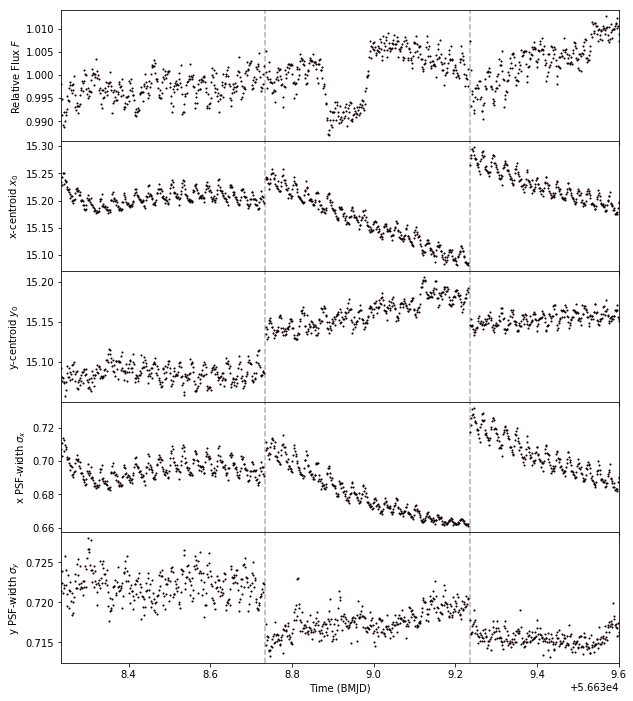

In [10]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 12))
#fig.suptitle("CoRoT-2b Observation")

axes[0].plot(time0, flux0,  'r.', markersize=1, alpha = 0.7)
axes[0].plot(time, flux,  'k.', markersize=2, alpha = 1.0)
axes[0].set_ylabel("Relative Flux $F$")
axes[0].set_xlim((np.min(time0), np.max(time0)))

axes[1].plot(time0, xdata0,  'r.', markersize=1, alpha = 0.7)
axes[1].plot(time, xdata,  'k.', markersize=2, alpha = 1.0)
axes[1].set_ylabel("x-centroid $x_0$")

axes[2].plot(time0, ydata0,  'r.', markersize=1, alpha = 0.7)
axes[2].plot(time, ydata, 'k.', markersize=2, alpha = 1.0)
axes[2].set_ylabel("y-centroid $y_0$")

axes[3].plot(time0, psfxw0,  'r.', markersize=1, alpha = 0.7)
axes[3].plot(time, psfxw, 'k.', markersize=2, alpha = 1.0)
axes[3].set_ylabel("x PSF-width $\sigma _x$")

axes[4].plot(time0, psfyw0,  'r.', markersize=1, alpha = 0.7)
axes[4].plot(time, psfyw,  'k.', markersize=2, alpha = 1.0)
axes[4].set_ylabel("y PSF-width $\sigma _y$")
axes[4].set_xlabel('Time (BMJD)')

for i in range(5):
    for j in range(len(breaks)):
        axes[i].axvline(x=breaks[j], color ='k', alpha=0.3, linestyle = 'dashed')
        
fig.subplots_adjust(hspace=0)
pathplot1 = savepath + '01_Raw_data.pdf'
fig.savefig(pathplot1, bbox_inches='tight')

In [11]:
# determine which parameter we do not need to fit
dparams = helpers.expand_dparams(dparams, mode)  

debug = False

# get p0
obj = p0_obj
p0, p0_labels, p0_fancyLabels = helpers.get_p0(p0_names, p0_fancyNames, dparams, p0_obj)
p0_signal  = p0
if 'sigF' in p0_labels:
    p0_signal = p0_signal[:-1]

# make lambda function
signalfunc = helpers.make_lambdafunc(helpers.signal_poly, dparams, p0_obj, debug=debug)
if debug:
    print()

# making lambda function for phasecurve and detector
astrofunc = helpers.make_lambdafunc(astro_models.ideal_lightcurve, dparams, p0_obj, debug=debug)
if debug:
    print()
detecfunc = helpers.make_lambdafunc(helpers.detec_model_poly, dparams, p0_obj, debug=debug)
if debug:
    print()

# make a lnprior laambda function
lnpriorfunc = helpers.make_lambdafunc(helpers.lnprior, dparams, obj=p0_obj, debug=debug)

# detemining which params in p0 is part of ideal_lightcurve and detec
p0_detec  = inspect.getargspec(helpers.detec_model_poly).args[1:]
p0_deval, p0_detec, p0_detecFancy  = helpers.get_p0(p0_detec, p0_fancyNames, dparams,p0_obj)

p0_astro  = inspect.getargspec(astro_models.ideal_lightcurve).args[1:-1]
p0_asval, p0_astro, p0_astroFancy = helpers.get_p0(p0_astro, p0_fancyNames, dparams,p0_obj)

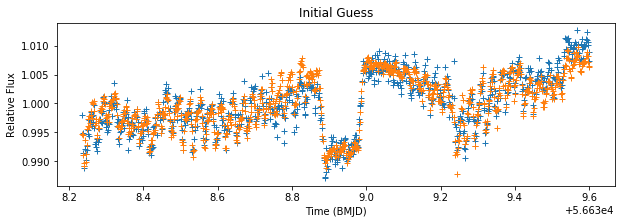

In [12]:
# initial astro model
astro = astrofunc(time, *p0_asval, mode)
resid = flux/astro

# get initial guess for detec model
p0_deval, _ = scipy.optimize.curve_fit(detecfunc, input_dat, resid, p0_deval)

# replace p0 with new detector coefficient values
for i in range(len(p0_detec)):
    index = np.where(np.in1d(p0_labels,p0_detec[i]))
    p0[index] = p0_deval[i]
    mystr = 'p0_obj.' + p0_detec[i] + '=' + str(p0_deval[i])
    exec(mystr)
    
# plot detector initial guess
init_detec = helpers.detec_model_poly(input_dat, *p0_deval)
make_plots.plot_detec_syst(time, flux, signalfunc(time, xdata, ydata, mid_x, 
                                                  mid_y, mode, *p0_signal))

## Preparing for MCMC

In [13]:
# instruction for sampling
ndim, nwalkers = len(p0), 300
# get scattered starting point in parameter space 
# MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
pos0 = [p0*(1+1e-5*np.random.randn(ndim))+1e-5*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]
   
#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, a = 2,
                                args=(signalfunc, lnpriorfunc, 
                                      flux, time, xdata, ydata, 
                                      mid_x, mid_y, mode, lnprior_custom))

if lnpriorfunc(*p0) != 0.0 or (lnprior_custom != 'none' and lnprior_custom(p0) != 0.0):
    print('Error: Initial values fail the lnprior and the following MCMC will not work!')

## Run MCMC

### First burn-in:

In [ ]:
tic = t.clock()

print('Running burn-in')
pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps/nwalkers))
print("Mean burn-in acceptance fraction: {0:.3f}\n"
                .format(np.mean(sampler.acceptance_fraction)))
sampler.reset()

toc = t.clock()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running burn-in


### Second burn-in

Continue from best spot from last time, and do quick burn-in to get walkers spread out

In [ ]:
tic = t.clock()
print('Running second burn-in')
pos2 = pos1[np.argmax(prob)]
# slightly change position of walkers to prevent them from taking the same path
pos2 = [pos2*(1+1e-6*np.random.randn(ndim))+1e-6*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]
pos2, prob, state = sampler.run_mcmc(pos2, np.rint(nBurnInSteps/nwalkers))
print('Mean burn-in acceptance fraction: {0:.3f}\n'
                .format(np.median(sampler.acceptance_fraction)))
sampler.reset()

toc = t.clock()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

### Run production
Run that will be saved

In [ ]:
tic = t.clock()
# Continue from last positions and run production
print('Running production')
pos3, prob, state = sampler.run_mcmc(pos2, np.rint(nProductionSteps/nwalkers))
print("Mean acceptance fraction: {0:.3f}\n"
                .format(np.mean(sampler.acceptance_fraction)))
toc = t.clock()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

## Saving MCMC Results

In [ ]:
pathchain = savepath + 'samplerchain_'+mode+'.npy'
pathposit = savepath + 'samplerposi_'+mode+'.npy'
np.save(pathchain, sampler.chain)
np.save(pathposit, pos3)

In [ ]:
#print the results
samples = sampler.chain.reshape((-1, ndim))

(MCMC_Results) = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0))))
p0_mcmc = np.median(samples, axis=0)

out = "MCMC result:\n\n"
for i in range(len(p0)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])

out += '{:>8} = {:>16}'.format('Offset', np.arctan(p0_mcmc[10]/p0_mcmc[9])*180/np.pi)

print(out)
with open(savepath+'MCMC_RESULTS_'+mode+'.txt','w') as file:
    file.write(out) 

In [ ]:
ind = len(p0_astro)
labels = p0_fancyLabels[:ind]

fname = savepath+'MCMC_'+mode+'_astroWalkers.pdf'
helpers.walk_style(ind, nwalkers, sampler.chain, 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

In [ ]:
labels = p0_fancyLabels[ind:]
fname = savepath+'MCMC_'+mode+'_detecWalkers.pdf'
helpers.walk_style(len(p0)-ind, nwalkers, sampler.chain[:,:,ind:], 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

In [ ]:
fig = corner.corner(samples[:,:ind], labels=p0_fancyLabels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = savepath + 'MCMC_'+mode+'_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [ ]:
if 'ecosw' in p0_labels and 'esinw' in p0_labels:
    '''Eccentricity and Longitude of Periastron Coefficient'''
    
    ind1 = p0_labels.index('ecosw')
    ind2 = p0_labels.index('esinw')
    e_chain = np.sqrt(samples[:,ind1]**2 + samples[:,ind2]**2)
    w_chain = np.arctan(samples[:,ind2]/samples[:,ind1])
    binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
    binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
    axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
    axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
    axes[1,0].set_title('$e$', fontsize=12)
    axes[1,1].set_title('$\omega$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_5.pdf'
    fig.savefig(plotname, bbox_inches='tight')

In [ ]:
if 'q1' in p0_labels and 'q2' in p0_labels:
    '''Stellar Limb Darkening Parameters'''
    
    ind1 = p0_labels.index('q1')
    ind2 = p0_labels.index('q2')
    u1_chain = 2*np.sqrt(samples[:,ind1]**2)*samples[:,ind2]
    u2_chain = np.sqrt(samples[:,ind1]**2)*(1-2*samples[:,ind2])
    binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
    binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
    axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$q_1$', fontsize=12)
    axes[0,1].set_title('$q_2$', fontsize=12)
    axes[1,0].set_title('$u_1$', fontsize=12)
    axes[1,1].set_title('$u_2$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_6.pdf'
    fig.savefig(plotname, bbox_inches='tight')

In [ ]:
#Clean out the RAM
samples = None
sampler = None

In [ ]:
time2 = np.linspace(np.min(time), np.max(time), 1000)
if 'sigF' in p0_labels:
    mcmc_det = detecfunc((xdata, ydata, mid_x, mid_y, mode), *(p0_mcmc[ind:-1]))
else:
    mcmc_det = detecfunc((xdata, ydata, mid_x, mid_y, mode), *(p0_mcmc[ind:]))
mcmc_lightplot = astrofunc(time2, *p0_mcmc[:ind], mode)
mcmc_lightcurve = astrofunc(time, *p0_mcmc[:ind], mode)

In [ ]:
if 't0' in p0_labels:
    t0MCMC = p0_mcmc[p0_labels.index('t0')]
else:
    t0MCMC = p0_obj.t0
if 'per' in p0_labels:
    perMCMC = p0_mcmc[p0_labels.index('per')]
else:
    perMCMC = p0_obj.per
x = (time-t0MCMC)/perMCMC
x -= int(x[0])

fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 10))
axes[0].set_xlim(np.min(x), np.max(x))
axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot(x, mcmc_lightcurve*mcmc_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_ylim(0.975, 1.0125)
axes[0].set_ylabel('Flux')

axes[1].plot(x, flux/mcmc_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot(x, mcmc_lightcurve, color = 'r', linewidth=2)
axes[1].set_ylabel('Flux')
axes[1].set_ylim(0.9825, 1.0125)
axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
axes[2].plot(x, flux/mcmc_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[2].plot(x, mcmc_lightcurve, color = 'r', linewidth=2)
axes[2].set_ylabel('Flux')
axes[2].set_ylim(0.996, 1.009)

axes[3].plot(x, flux/mcmc_det - mcmc_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[3].axhline(y=0, color='r', linewidth = 2)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Orbital Phase')
axes[3].set_ylim(-0.007, 0.007)

fig.subplots_adjust(hspace=0)
plotname = savepath + 'MCMC_'+mode+'_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

# Is $\chi ^2$ improving?

In [ ]:
#Binned data
data = (flux/mcmc_det)
fit  = mcmc_lightcurve
if 'sigF' in p0_labels:
    sigFMCMC = p0_labels.index('sigF')
else:
    sigFMCMC = p0_obj.sigF
err = np.ones(len(data))*sigFMCMC
chisB = helpers.chi2(data, fit, err)
logLB = helpers.loglikelihood(data, fit, err)
EB = helpers.BIC(logLB, ndim, len(data))


#Unbinned data
#nFrames = 64
if ignoreFrames != []:
    nFrames2 = nFrames - len(ignoreFrames)

'''Full Data'''
flux_full, ferr_full, time_full, x_full, y_full = helpers.get_full_data(foldername, filename)

'''Order in chronological order'''
index = np.argsort(time_full)
flux_full = flux_full[index]
ferr_full = ferr_full[index]
time_full = time_full[index]
x_full    = x_full[index]
y_full    = y_full[index]

'''Sigma clip per data cube'''
flux_clean = []
x_clean    = []
y_clean    = []

for i in range(len(time)):
    beg = int(i*nFrames2)
    end = int((i+1)*nFrames2)
    flux_clean = np.ma.append(flux_clean, sigma_clip(flux_full[beg:end]))
    x_clean = np.ma.append(x_clean, sigma_clip(x_full[beg:end]))
    y_clean = np.ma.append(y_clean, sigma_clip(y_full[beg:end]))

'''Normalize flux'''
flux_clean = flux_clean/np.ma.median(flux_clean)

'''Get model'''
if 'sigF' in p0_labels:
    det_full = detecfunc((x_clean, y_clean, mid_x, mid_y, mode), *(p0_mcmc[ind:-1]))
else:
    det_full = detecfunc((x_clean, y_clean, mid_x, mid_y, mode), *(p0_mcmc[ind:]))

# properly remove centroid outliers
det_full = np.ma.masked_array(det_full, mask=(y_clean.mask+x_clean.mask))

lc_full  = astrofunc(time_full, *p0_mcmc[:ind], mode)

model_full = det_full*lc_full

'''Get Fitted Uncertainty'''
ferr_clean = np.ones(len(flux_clean))*sigFMCMC*np.sqrt(nFrames)
ferr_clean = np.ma.masked_array(ferr_clean, mask = model_full.mask)

N = len(model_full)-np.sum((model_full).mask)

chis = helpers.chi2(flux_clean, model_full, ferr_clean)
logL = helpers.loglikelihood(flux_clean, lc_full*det_full, ferr_clean)
E = helpers.BIC(logL, ndim, N)

out = """{0}
Likelihood: {1}
Evidence: {2}
$\chi ^2 = $ {3}
$\ln(L)=$ {4}
$E =${5}""".format(chisB, logLB, EB, chis, logL, E) 
with open(savepath+'EVIDENCE_'+mode+'.txt','w') as file:
    file.write(out)
print(out)

In [ ]:
ResultMCMC_Params = Table()

for i in range(len(p0_labels)):
    ResultMCMC_Params[p0_labels[i]] = MCMC_Results[i]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = savepath + 'ResultMCMC_'+mode+'_Params.npy'
np.save(pathres, ResultMCMC_Params)

In [ ]:
# determining in-eclipse and in-transit index

# generating transit model

if 't0' in p0_labels:
    t0MCMC = p0_mcmc[p0_labels.index('t0')]
else:
    t0MCMC = p0_obj.t0
if 'per' in p0_labels:
    perMCMC = p0_mcmc[p0_labels.index('per')]
else:
    perMCMC = p0_obj.per
if 'rp' in p0_labels:
    rpMCMC = p0_mcmc[p0_labels.index('rp')]
else:
    rpMCMC = p0_obj.rp
if 'a' in p0_labels:
    aMCMC = p0_mcmc[p0_labels.index('a')]
else:
    aMCMC = p0_obj.a
if 'inc' in p0_labels:
    incMCMC = p0_mcmc[p0_labels.index('inc')]
else:
    incMCMC = p0_obj.inc
if 'ecosw' in p0_labels:
    ecoswMCMC = p0_mcmc[p0_labels.index('ecosw')]
else:
    ecoswMCMC = p0_obj.ecosw
if 'esinw' in p0_labels:
    esinwMCMC = p0_mcmc[p0_labels.index('esinw')]
else:
    esinwMCMC = p0_obj.esinw
if 'q1' in p0_labels:
    q1MCMC = p0_mcmc[p0_labels.index('q1')]
else:
    q1MCMC = p0_obj.q1
if 'q2' in p0_labels:
    q2MCMC = p0_mcmc[p0_labels.index('q2')]
else:
    q2MCMC = p0_obj.q2
if 'fp'in p0_labels:
    fpMCMC = p0_mcmc[p0_labels.index('fp')]
else:
    fpMCMC = p0_obj.fp

eccMCMC = np.sqrt(ecoswMCMC**2 + esinwMCMC**2)
wMCMC   = np.arctan2(esinwMCMC, ecoswMCMC)
u1MCMC  = 2*np.sqrt(q1MCMC)*q2MCMC
u2MCMC  = np.sqrt(q1MCMC)*(1-2*q2MCMC)

trans, t_sec, true_anom = astro_models.transit_model(time, t0MCMC, perMCMC, rpMCMC,
                                                   aMCMC, incMCMC, eccMCMC, wMCMC,
                                                   u1MCMC, u2MCMC)
# generating secondary eclipses model
eclip = astro_models.eclipse(time, t0MCMC, perMCMC, rpMCMC, aMCMC, incMCMC, eccMCMC, wMCMC,
                             u1MCMC, u2MCMC, fpMCMC, t_sec)

# get in-transit indices
ind_trans  = np.where(trans!=1)
# get in-eclipse indices
ind_eclip  = np.where((eclip!=(1+fpMCMC)))
# seperating first and second eclipse
ind_ecli1 = ind_eclip[0][np.where(ind_eclip[0]<int(len(time)/2))]
ind_ecli2 = ind_eclip[0][np.where(ind_eclip[0]>int(len(time)/2))]


In [ ]:
residual = flux/mcmc_det - mcmc_lightcurve

data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecli1], ydata[ind_ecli1], psfxw[ind_ecli1], psfyw[ind_ecli1], flux[ind_ecli1], residual[ind_ecli1]]
data3 = [xdata[ind_trans], ydata[ind_trans], psfxw[ind_trans], psfyw[ind_trans], flux[ind_trans], residual[ind_trans]]
data4 = [xdata[ind_ecli2], ydata[ind_ecli2], psfxw[ind_ecli2], psfyw[ind_ecli2], flux[ind_ecli2], residual[ind_ecli2]]
label = [r'$x_0$', r'$y_0$', r'$\sigma _x$', r'$\sigma _y$', r'$F$', r'Residuals']

plotname = savepath + 'MCMC_'+mode+'_7.pdf'
helpers.triangle_colors(data1, data2, data3, data4, label, plotname)